## ECG Data Compression by Wavelet Transform
Based on "Effective high compression of ECG signals at low level distortion" by Laura Rebollo-Neira

### Step 0: Import Libraries

In [35]:
%matplotlib inline
from scipy.stats import iqr
import sys
from scipy.signal import detrend

### Load Data

In [1]:
import mne
file = "/Users/juseo\Documents\dyuku\summer 20\dbdp\code\DBDP_Compression_Toolbox/Joe/ECG.EDF"
data = mne.io.read_raw_edf(file)
raw_data = data.get_data()

import numpy as np
header = ','.join(data.ch_names)
np.savetxt('ECG.csv', data.get_data().T, delimiter=',', header=header)

import pandas as pd
df0 = pd.read_csv('ECG.csv')
df = df0.iloc[:,0:1] #obtain # ECG channel data

Extracting EDF parameters from C:\Users\juseo\Documents\dyuku\summer 20\dbdp\code\DBDP_Compression_Toolbox\Joe\ECG.EDF...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


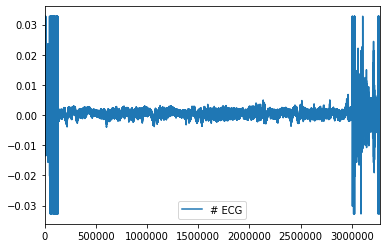

In [4]:
import matplotlib.pyplot as plt
df.plot()

### Truncate Data
Find endpoints at which to truncate

(0, 300000)

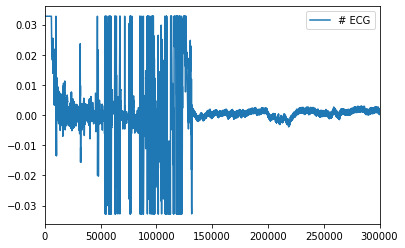

In [5]:
df.plot()
plt.xlim(0,300000)
#choose approximately 150000

(2750000, 3270000)

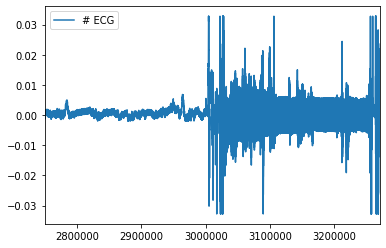

In [6]:
df.plot()
plt.xlim(2750000,3270000)
#choose approximately 2980000

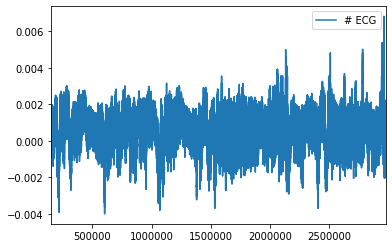

In [9]:
df = df.truncate(before = 150000, after = 2979999)
df.plot()

In [10]:
df.index

RangeIndex(start=150000, stop=2980000, step=1)

In [11]:
df.size

2830000

In [12]:
df.head(5)

,# ECG
150000,-0.000597
150001,-0.000590
150002,-0.000568
150003,-0.000557
150004,-0.000568


In [13]:
df.tail(5)

,# ECG
2979995,-0.000213
2979996,-0.000280
2979997,-0.000324
2979998,-0.000302
2979999,-0.000235


### Step 1: Approximation
**Input:** Array **w** of wavelets coefficients & parameter *tol* for the approximation error  
**Output:** Indices *l*<sub>i</sub>, i=1,...,*K* of the selected wavelet coefficients. Array **c** with the selected wavelet coefficients.

#### Part A: DWT transform
Array *data* with the N-dimensional signal. Decomposition level *lv*.  
Wavelet used: bior4.4.

In [14]:
import pywt
from pywt import wavedec
def dwt(data, lv):
    cA5, cD5, cD4, cD3, cD2, cD1 = wavedec(data, 'bior4.4', level=lv)
    coeffs = {'cA5': cA5, 'cD5': cD5, 'cD4': cD4, 'cD3': cD3, 'cD2': cD2, 'cD1': cD1}
    return coeffs

In [15]:
coeffs = dwt(df,5)

C:\Users\juseo\Anaconda3\lib\site-packages\pywt\_multilevel.py:45: UserWarning: Level value of 5 is too high: all coefficients will experience boundary effects.
  "boundary effects.").format(level))


Plot of wavelet decomposition for all levels


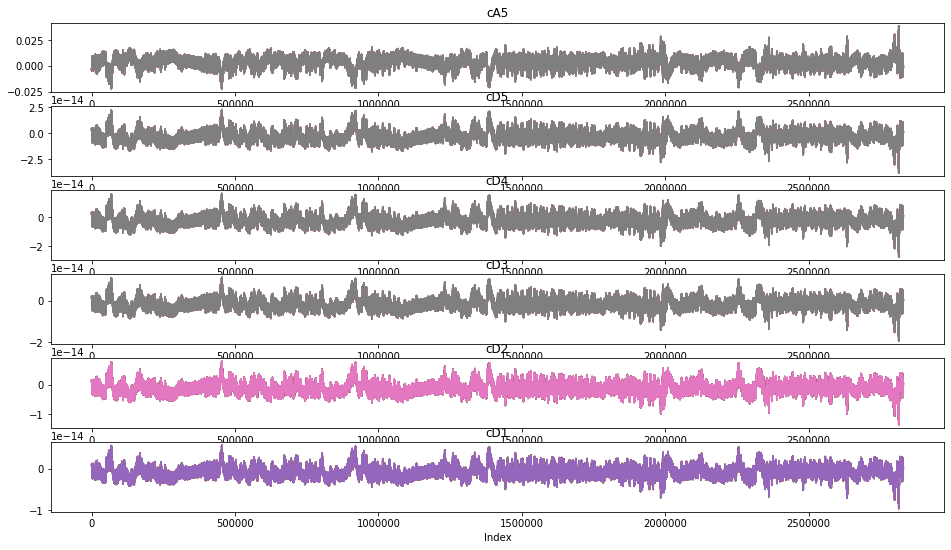

In [18]:
print('Plot of wavelet decomposition for all levels')
plt.subplots(figsize=(16,9))

plt.subplot(6,1,1)
plt.plot(coeffs['cA5'])
plt.title('cA5')

plt.subplot(6,1,2)
plt.plot(coeffs['cD5'])
plt.title('cD5')

plt.subplot(6,1,3)
plt.plot(coeffs['cD4'])
plt.title('cD4')

plt.subplot(6,1,4)
plt.plot(coeffs['cD3'])
plt.title('cD3')

plt.subplot(6,1,5)
plt.plot(coeffs['cD2'])
plt.title('cD2')

plt.subplot(6,1,6)
plt.plot(coeffs['cD1'])
plt.title('cD1')
plt.xlabel('Index')

plt.show()

In [19]:
coeffs

{'cA5': array([[-0.00337714, -0.00337714, -0.00337714, ..., -0.00337714,
         -0.00337714, -0.00337714],
        [-0.00333754, -0.00333754, -0.00333754, ..., -0.00333754,
         -0.00333754, -0.00333754],
        [-0.00321309, -0.00321309, -0.00321309, ..., -0.00321309,
         -0.00321309, -0.00321309],
        ...,
        [-0.00183282, -0.00183282, -0.00183282, ..., -0.00183282,
         -0.00183282, -0.00183282],
        [-0.00170837, -0.00170837, -0.00170837, ..., -0.00170837,
         -0.00170837, -0.00170837],
        [-0.00132936, -0.00132936, -0.00132936, ..., -0.00132936,
         -0.00132936, -0.00132936]]),
 'cD5': array([[3.37775055e-15, 3.37775055e-15, 3.37775055e-15, ...,
         3.37742529e-15, 3.37802160e-15, 3.37775055e-15],
        [3.33823138e-15, 3.33804165e-15, 3.33806875e-15, ...,
         3.33817717e-15, 3.33825849e-15, 3.33828559e-15],
        [3.21354813e-15, 3.21354813e-15, 3.21354813e-15, ...,
         3.21343971e-15, 3.21352103e-15, 3.21354813e-15],

Test reconstruction of wavelets using coefficient matrices

In [20]:
recon = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], 'bior4.4')

In [21]:
recon

array([[-0.000597, -0.000597],
       [-0.00059 , -0.00059 ],
       [-0.000568, -0.000568],
       ...,
       [-0.000324, -0.000324],
       [-0.000302, -0.000302],
       [-0.000235, -0.000235]])

Wavelet Object: https://pywavelets.readthedocs.io/en/latest/regression/wavelet.html  
DWT API: https://pywavelets.readthedocs.io/en/latest/ref/dwt-discrete-wavelet-transform.html#ref-dwt   
Handling DWT Coeffs: https://pywavelets.readthedocs.io/en/latest/ref/dwt-coefficient-handling.html

#### Part B: Selection of the largest wavelet coefficients

Thresholds the wavelet coefficients to a specified energy.  
Different levels of decomposition are thresholded at different energy percentages.
1. Calculate the energy of all the coefficients.
1. Sort the coefficients from highest to lowest.
1. Calculate the energy as each new coefficient is added.
1. Repeat until the percentage is above the threshold.

In [23]:
#sort the absolute value of the coefficients in descending order
tmp_coeffs = index_coeffs = np.sort(np.abs(coeffs['cA5']))
tmp_coeffs

array([[0.00337714, 0.00337714, 0.00337714, ..., 0.00337714, 0.00337714,
        0.00337714],
       [0.00333754, 0.00333754, 0.00333754, ..., 0.00333754, 0.00333754,
        0.00333754],
       [0.00321309, 0.00321309, 0.00321309, ..., 0.00321309, 0.00321309,
        0.00321309],
       ...,
       [0.00183282, 0.00183282, 0.00183282, ..., 0.00183282, 0.00183282,
        0.00183282],
       [0.00170837, 0.00170837, 0.00170837, ..., 0.00170837, 0.00170837,
        0.00170837],
       [0.00132936, 0.00132936, 0.00132936, ..., 0.00132936, 0.00132936,
        0.00132936]])

In [24]:
index_coeffs

array([[0.00337714, 0.00337714, 0.00337714, ..., 0.00337714, 0.00337714,
        0.00337714],
       [0.00333754, 0.00333754, 0.00333754, ..., 0.00333754, 0.00333754,
        0.00333754],
       [0.00321309, 0.00321309, 0.00321309, ..., 0.00321309, 0.00321309,
        0.00321309],
       ...,
       [0.00183282, 0.00183282, 0.00183282, ..., 0.00183282, 0.00183282,
        0.00183282],
       [0.00170837, 0.00170837, 0.00170837, ..., 0.00170837, 0.00170837,
        0.00170837],
       [0.00132936, 0.00132936, 0.00132936, ..., 0.00132936, 0.00132936,
        0.00132936]])

In [25]:
print(len(tmp_coeffs))
print(len(coeffs['cA5']))

2830000
2830000


In [26]:
#find cumulative sum of square of each value
nerror = np.cumsum(np.square(tmp_coeffs),axis=0)
nerror

array([[1.14050880e-05, 1.14050880e-05, 1.14050880e-05, ...,
        1.14050880e-05, 1.14050880e-05, 1.14050880e-05],
       [2.25442880e-05, 2.25442880e-05, 2.25442880e-05, ...,
        2.25442880e-05, 2.25442880e-05, 2.25442880e-05],
       [3.28682560e-05, 3.28682560e-05, 3.28682560e-05, ...,
        3.28682560e-05, 3.28682560e-05, 3.28682560e-05],
       ...,
       [7.31426553e+01, 7.31426553e+01, 7.31426553e+01, ...,
        7.31426553e+01, 7.31426553e+01, 7.31426553e+01],
       [7.31426582e+01, 7.31426582e+01, 7.31426582e+01, ...,
        7.31426582e+01, 7.31426582e+01, 7.31426582e+01],
       [7.31426600e+01, 7.31426600e+01, 7.31426600e+01, ...,
        7.31426600e+01, 7.31426600e+01, 7.31426600e+01]])

In [27]:
#approximation error parameter
tol = 0.85 * np.amax(tmp_coeffs,axis=0)
tol

array([0.03282644, 0.03282644, 0.03282644, 0.03282644, 0.03282644,
       0.03282644, 0.03282644, 0.03282644])

In [28]:
tol[0]

0.03282644236709182

In [29]:
#indices of largest coefficients up to square error
indices = np.where(nerror >= tol[0]**2)
indices

(array([    109,     109,     109, ..., 2829999, 2829999, 2829999],
       dtype=int64), array([0, 1, 2, ..., 5, 6, 7], dtype=int64))

In [30]:
tmp_coeffs = coeffs['cA5'][indices]
tmp_coeffs

array([-0.00398808, -0.00398808, -0.00398808, ..., -0.00132936,
       -0.00132936, -0.00132936])

In [31]:
N = len(tmp_coeffs)
sampling_freq = 1/1000
index = np.linspace(0, round((N-1)*sampling_freq,4), N)
index

array([0.0000000e+00, 1.0000000e-03, 2.0000000e-03, ..., 2.2639125e+04,
       2.2639126e+04, 2.2639127e+04])

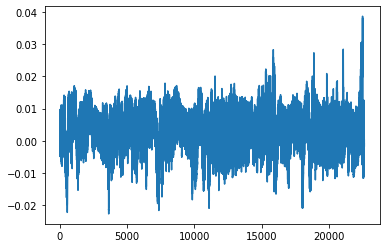

In [32]:
plt.plot(index,tmp_coeffs)

In [43]:
np.nonzero(csums)

(array([     29,      29,      29, ..., 3269999, 3269999, 3269999],
       dtype=int64), array([0, 1, 2, ..., 5, 6, 7], dtype=int64))

In [55]:
np.swapaxes(coeffs['cA5'],0,1)

array([[0.18535814, 0.18535814, 0.18535814, ..., 0.00976373, 0.00794222,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.00976373, 0.00794222,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.00976373, 0.00794222,
        0.0064771 ],
       ...,
       [0.18535814, 0.18535814, 0.18535814, ..., 0.00976373, 0.00794222,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.00976373, 0.00794222,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.00976373, 0.00794222,
        0.0064771 ]])

In [56]:
selected = coeffs['cA5'][inds_to_keep]

In [65]:
np.swapaxes(selected,0,1)

array([[0.18535814, 0.18535814, 0.18535814, ..., 0.0064771 , 0.0064771 ,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.0064771 , 0.0064771 ,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.0064771 , 0.0064771 ,
        0.0064771 ],
       ...,
       [0.18535814, 0.18535814, 0.18535814, ..., 0.0064771 , 0.0064771 ,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.0064771 , 0.0064771 ,
        0.0064771 ],
       [0.18535814, 0.18535814, 0.18535814, ..., 0.0064771 , 0.0064771 ,
        0.0064771 ]])

In [66]:
len(np.swapaxes(selected,0,1)[0])

26159760

In [64]:
len(selected)

26159760

#### Compile above code into a function for all matrices of wavelet coefficients

In [ ]:
import copy

def select_coeffs(coeffs):
    #make a deep copy of coeffs to retain the original version
    coeffs_orig = copy.deepcopy(coeffs)
    
    nonzero_coeff_count = {}
    
    for key in coeffs.keys():
        #sort the absolute value of the coefficients in descending order
        tmp_coeffs = np.sort(np.abs(coeffs[key]))
        
        #find cumulative sum of square of each value
        csums = np.cumsum(np.square(tmp_coeffs),axis=0)
        
        #approximation error parameter
        tol = 0.85 * max(tmp_coeffs)
        
        #set any coefficients below the threshold to zero
        inds_to_zero = np.where((csums < tol))[0]
        csums[inds_to_zero] = 0
        
        #array of nonzero terms
        np.nonzero(csums)
        
        #indices of absolute value of coefficients that would sort in ascending order
        indices = np.argsort(np.abs(coeffs[key]),axis=0)
        
        #indices of coefficients above threshold
        inds_to_keep = np.where((indices > np.nonzero(csums)[0]))[0]
        
        #create
        np.swapaxes(coeffs[key],0,1)
        selected = coeffs[key][inds_to_keep]
        
        #create array of selected wavelet coefficients + store length of each
        coeffs[key] = selected
        nonzero_coeff_count[key] = len(tmp_coeffs)
        
    return nonzero_coeff_count

### Step 2: Quantization
A mid-tread uniform quantizer transforms the selected wavelet coefficients into integers.

Scale the wavelet coefficients to the [0,1] range.

In [ ]:
def scale_coeffs(coeffs, do_plot=False):
    coeffs_scaled = {}
    scaling_factors = {}

    for key in coeffs.keys():
        shift_factor = np.min(coeffs[key])
        coeffs_tmp = coeffs[key]-shift_factor

        scale_factor = np.max(coeffs_tmp)
        coeffs_tmp = coeffs_tmp/scale_factor

        scaling_factors[key] = {'shift_factor': shift_factor, 'scale_factor': scale_factor}
        coeffs_scaled[key] = coeffs_tmp
    return coeffs_scaled, scaling_factors

Calculate the lowest possible number of bits to quantize the wavelet coefficients such that the PRD is above the threshold.
1. Quantize the signal starting at 8 bits
1. Unquantize and reconstruct the signal
1. Calculate the PRD.
1. Repeat with 1 fewer bit (ie, 7 bits), ...

In [ ]:
def calculate_num_bits(orig_sig, coeffs_scaled, binary_map, scaling_factors, do_plot=False):
    #starting at 8 bits, keep decreasing the number of bits in the quantization
    #until the PRD is above some threshold
    num_bits = 9

    #initialize PRD to 0 so the while loop can run
    PRD = 0

    #keep track of PRD per number of bits
    PRD_dict = {}
    
    while (num_bits >= 5) and (PRD <= MAX_PRD):
        #decrement the number of bits
        num_bits = num_bits-1

        coeffs_quantized = do_quantization(coeffs_scaled, num_bits)

        #rescale the coefficients
        coeffs_unscaled = unscale_coeffs(None, coeffs_quantized, scaling_factors, num_bits)

        #do the inverse dwt
        data_reconstructed = wavelet_reconstruction(coeffs_unscaled, None, None)

        #calculate PRD
        PRD = calculate_PRD(orig_sig, data_reconstructed)
        PRD_dict[num_bits] = PRD

        #plot the reconstructed signals 
        if do_plot:
            if PRD <= MAX_PRD:
                plt.plot(t, data_reconstructed, label='Reconstructed @ %i Bits, PRD = %.2f' % (num_bits, PRD))

    #if we went over the PRD, go back up by one bit
    if PRD > MAX_PRD:
        num_bits = num_bits+1
        PRD = PRD_dict[num_bits]
    
    return num_bits, PRD

Quantization:
1. Take in the scaled wavelet coefficients
1. Multiply by 2^(num bits)
1. Round to the nearest integer.

In [ ]:
def do_quantization(coeffs, bits, do_plot=False):
    quantized_coeffs = {}

    for key in coeffs.keys():
        sig = coeffs[key]
        sig = sig*(2**bits-1)
        sig = np.round(sig)
        sig = np.array(sig).astype(int)

        quantized_coeffs[key] = sig
        
    return quantized_coeffs

### Step 3: Organization and Storage Step
1. Re-order indices in ascending order. This re-orders coefficients and corresponding signs.
1. Store re-ordered indices as smaller positive numbers by taking differences between two consecutive values. 
1. Save the size of the singal, the quantization parameter, and the arrays (reordered coefficients, signs, and indices) in HDF5 format.

#### Reference MATLAB Code

In [ ]:
#
clear 
# Options
baseline=0 # does not modify raw data
mywname='cdf97' # wavelet family
wlevel=4 # decomposition level
store=0 # Change to 1 to add Huffman entropy coding

dat=input('Please enter record number (from the MIT_BIHA_database) \n ','s');
icase=input('Please enter approximation method (a or b) \n','s');
if icase=='a'
PRD0=input('Please enter PRD0 (e.g. 0.4217)  \n');
end

del=input('Please enter quantization parameter (e.g. 32 for a) and 39 for b) \n');
%

filenamer=['ECG_Compression/MIT_BIHA_DATA/Record_' char(strcat(dat, '_11bits.dat'))];
filenamew_tmp='ECG_Compression/Comp_Record.mat'
fid=fopen(filenamer,'r');
f=fread(fid,'ubit11');
fclose(fid);

f=f-baseline;
tic
base=0;
[fw,wl]=mydwt(f,wlevel,mywname);
L=numel(fw);
if icase=='a'
tol=PRD0*norm(f)/100;
[cs,wind]=SLWC(fw,tol);
end
if icase=='b'
cs=fw;
wind=1:numel(fw);
wind=wind';
end

# quantization of wavelet coefficients
csq=sign(cs).*floor(abs(cs)/del+0.5);
I0=find(csq==0);
if isempty(I0)==0 # remove the zeros
csq(I0)=[];
wind(I0)=[];
end

# Organization and Storage
clear vc vi vs
[or,ior]=sort(wind); # sort the indices
vc=abs(csq(ior)); 

# take differences
vi=[or(1) diff(or)'];
# invert with cumsum([vi]);
# vi=vdif(or); # take differences
vs=(sign(csq(ior))+ 1)./2; # encode the signs as zeros and ones

if store==0;
save (filenamew_tmp, 'del','L', 'vi', 'vc', 'vs'); # save in HDF5 format
else
xS{1}=vs;
xC{1}=vi;
xCC{1}=vc;
ys=Huff06(xS);
yc=Huff06(xCC);
yi=Huff06(xC);
save (filenamew_tmp, 'del','L','yi','yc','ys'); # save in HDF5 format
end
hf11=dir(filenamer);
hfH=dir(filenamew_tmp);
CR=hf11.bytes/hfH.bytes #calculate CR
toc

## Data Reconstruction

### Wavelet Reconstruction

In [ ]:
def dwt_reconstruct(coeffs):
    reconstructed = pywt.waverec([coeffs['cA5'], coeffs['cD5'], coeffs['cD4'], coeffs['cD3'], 
                                    coeffs['cD2'], coeffs['cD1']], 'bior4.4')
    return reconstructed